##  3.5证据近似

引入超参数$\alpha$和$\beta$上的超先验分布，那么预测分布可以写为:
$$p(t|\mathbf t)=\iiint p(t|\mathbf {w},\beta)p(w|\mathbf t,\alpha,\beta)p(\alpha,\beta|\mathbf t)dwd\alpha d\beta$$

固定$\alpha$,$\beta$为$\hat \alpha$,$\hat\beta$:

$$p(t|\mathbf t)\simeq p(t|\mathbf t,\hat \alpha,\hat\beta)=\int p(t|\mathbf w,\hat\beta)p(w|\mathbf t,\hat\alpha,\hat\beta)dw$$

根据贝叶斯定理,$\alpha, \beta$的后验分布为:
$$p(\alpha,\beta|\mathbf t)\propto p(\mathbf t|\alpha,\beta)p(\alpha,\beta)$$

在这个框架下$\hat\alpha, \hat\beta$就可以通过最大化边缘似然函数$p(\mathbf t|\alpha,\beta)$来求出,我们接下来会计算线性基函数模型的边缘似然函数，然后找到它的最⼤值。这将使我们能够从训练数据本⾝确定这些超参数的值，⽽不需要交叉验证
$$p(\mathbf t|\alpha,\beta)=\int p(t|\mathbf w,\beta)p(\mathbf w|\alpha)dw$$
通过线性高斯模型的条件概率公式或使用指数项配平的方法我们可以得到对数似然：
$$lnp(\mathbf t|\alpha,\beta)=\frac{M}{2}ln\alpha+\frac{N}{2}ln\beta-E(m_N)-\frac{1}{2}ln|A|-\frac{N}{2}ln(2\pi)$$
$$m_N=\beta A^{-1}\Phi^T\mathbf t$$
$$A=\alpha\mathbf I+\beta\Phi^T\Phi$$

### 最大化证据函数

$p(\mathbf t|\alpha,\beta)$对$\alpha$最大化
定义:$$(\beta\Phi^T\Phi)\mu_i=\lambda_i\mu_i$$
似然函数中$ln|A|$的项关于$\alpha$的导数为:

$$\frac{d}{d\alpha}ln|A|=\frac{d}{d\alpha}ln\prod_i(\lambda_i+\alpha)=\frac{d}{d\alpha}\sum_iln(\lambda_i+\alpha)=\sum_i\frac{1}{\lambda_i+\alpha}$$

所以$\alpha$满足:
$$\alpha=\frac{\gamma}{m_N^Tm_N}\\
\gamma=\sum_i\frac{\lambda_i}{\alpha+\lambda_i}$$
可以发现$\alpha$无法显示求解，后验概率的众数$m_N$和$\gamma$都与$\alpha$有关。只有选择一个$\alpha$的初始值然后计算A再算出$m_N$，然后计算$\gamma$,最后估计$\alpha$，迭代直至收敛

类似的关于$\beta$最⼤化对数边缘似然函数:
$$\frac{d}{d\beta}ln|A|=\frac{d}{d\beta}\sum_iln(\lambda_i+\alpha)=\frac{1}{\beta}\sum_i\frac{\lambda_i}{\lambda_i+\alpha}=\frac{\gamma}{\beta}$$
整理得到:
$$\beta^{-1}=\frac{1}{N-\gamma}\sum_{n=1}^{N}\{t_n-m_N^T\phi(x_n)\}^2$$

In [14]:
import sys
#sys.path
sys.path.append("../")
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from prml.linear import EmpiricalBayesRegressor
from prml.features import PolynomialFeatures

np.random.seed(666)

In [15]:
def cubic(x):
    return x*(x-5)*(x+5)
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t
x_train, y_train = create_toy_data(cubic, 30, 10, [-5, 5])
print(x_train)

[ 2.24137931 -1.20689655 -3.96551724  0.17241379  0.86206897  3.96551724
 -5.          3.62068966 -1.55172414  1.20689655  3.27586207  2.93103448
  1.89655172  4.31034483  5.          4.65517241 -3.27586207 -2.5862069
 -2.24137931  2.5862069   0.51724138 -4.65517241 -0.17241379  1.55172414
 -3.62068966 -1.89655172 -2.93103448 -0.51724138 -4.31034483 -0.86206897]


In [16]:
y_train

array([-36.94057427,  23.70618248,  42.91497387,  -6.4799834 ,
       -18.69137027, -55.45239397,  -2.55847593, -60.69600399,
        25.63181908, -44.21903526, -37.69511769, -56.35828552,
       -32.38193328, -24.00515234,  16.53995858, -14.10414318,
        34.57084836,  37.40794156,  29.12942484, -63.64531567,
        -0.47516586,   6.36278708,   1.5967789 , -20.85429654,
        33.22955177,  48.68972004,  66.61597553,  29.57455453,
        17.86871913,  25.6141747 ])

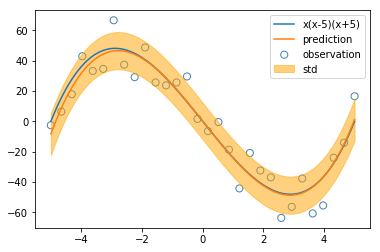

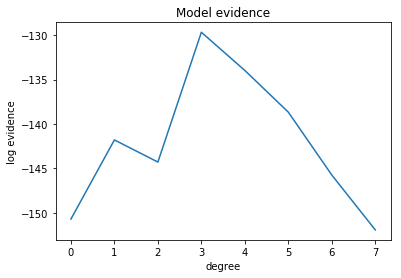

In [17]:
x_test = np.linspace(-5, 5, 100)
evidences = []
models = []
for i in range(8):
    feature = PolynomialFeatures(degree=i)
    X_train = feature.transform(x_train)
    model = EmpiricalBayesRegressor(alpha=100., beta=100.)
    model.fit(X_train, y_train, max_iter=100)
    evidences.append(model.log_evidence(X_train, y_train))
    models.append(model)

degree = np.nanargmax(evidences)
regression = models[degree]

X_test = PolynomialFeatures(degree=int(degree)).transform(x_test)
y, y_std = regression.predict(X_test, return_std=True)

ax,fig=plt.subplots(2,1)plt.scatter(x_train, y_train, s=50, facecolor="none", edgecolor="steelblue", label="observation")
plt.plot(x_test, cubic(x_test), label="x(x-5)(x+5)")
plt.plot(x_test, y, label="prediction")
plt.fill_between(x_test, y - y_std, y + y_std, alpha=0.5, label="std", color="orange")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("degree")
plt.ylabel("log evidence")
plt.show()